# Linguistics Project

#### Goal: Predict Emotions from recorded speech

In [124]:
import numpy as np
from sklearn.decomposition import KernelPCA
import seaborn as sns
import wave
import sys
import os
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import glob
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize 
from sklearn.pipeline import Pipeline

In [125]:
data_dir = '../data/Audio_Speech_Actors_01-24/Actor_07'
data_file = '03-01-01-01-01-01-07.wav'

data_path = os.path.join(data_dir, data_file)

In [126]:
def list_all_files(path='../data/Audio_Speech_Actors_01-24/'):
    relevant_files_regex = 'Actor_*/03-01-*.wav'
    relevant_files_list = glob.glob(path + relevant_files_regex)
    return relevant_files_list

In [127]:
#STFT https://towardsdatascience.com/audio-processing-in-tensorflow-208f1a4103aa
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    # Take segments from the signal
    nperseg = int(round(window_size * sample_rate / 1e3))
    # provides a 'smoother' spec compared to with 0 overlap
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    # Transpose spec-matrix into a 32-float array
    spectrogram = spec.astype(np.float32)
    #log_spectrogram = np.log10(spectrogram + eps)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return freqs, times, log_spectrogram

../data/Audio_Speech_Actors_01-24/Actor_22/03-01-03-01-01-02-22.wav
[-3.9638000e-09  4.6123327e-09 -5.1404183e-09 ... -1.6843335e-07
  2.2716112e-07  0.0000000e+00] 22050
Length in Nr. of Samples: 33792


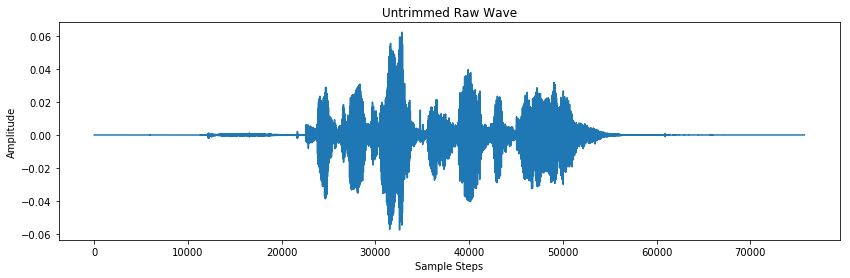

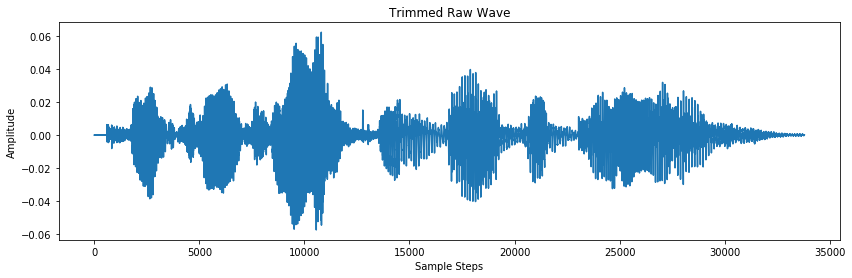

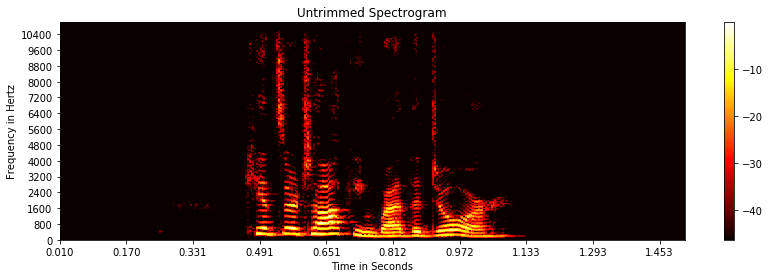

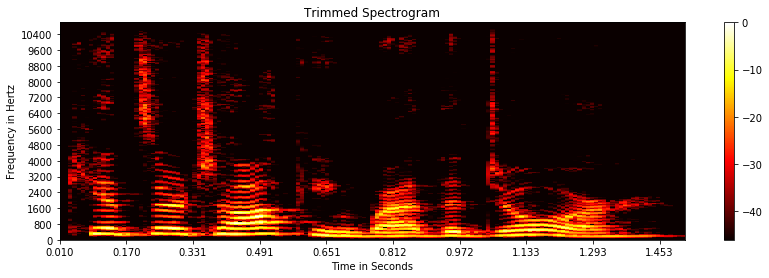

In [128]:
# Draw and plot random sample + its spectrogram

#trim all noise below 30Db at the beginning and end of time-axes
#trim one specific file

relevant_files_list = list_all_files()
file_name = random.choice(relevant_files_list)
print(file_name)
raw_samples, sample_rate = librosa.load(file_name)
#raw_samples, sample_rate = librosa.load(relevant_files_list[20])
print(raw_samples, sample_rate)
samples, index = librosa.effects.trim(raw_samples, top_db=35)

#untrimed spectrogram
freqs, times, untr_spectrogram = log_specgram(raw_samples, sample_rate)

#trimed spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)
#untrimed spectrogram
print('Length in Nr. of Samples: {}'.format(len(samples)))

#fig = plt.figure(figsize=(14, 8))
#ax1 = fig.add_subplot(211)
#ax1.set_title('Raw Wave')
#ax1.set_ylabel('Amplitude')
#ax1.set_xlabel('Sample Steps')
#ax1.plot(samples)

#ax2 = fig.add_subplot(212)
#s = ax2.imshow(spectrogram, aspect='auto', cmap='hot', origin='lower', 
#           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
#ax2.set_yticks(freqs[::16])
#ax2.set_xticks(times[::16])
#plt.colorbar(s, ax=ax2, format='%+02.0f')
#ax2.set_title('Spectrogram')
#ax2.set_ylabel('Frequency in Hertz')
#ax2.set_xlabel('Time in Seconds')
#plt.savefig('../graphics/raw_wave_spectrogram.pdf')

# raw wave untrimed
plt.figure(figsize=(14,4))
plt.title('Untrimmed Raw Wave')
plt.ylabel('Amplitude')
plt.xlabel('Sample Steps')
#plt(samples)
plt.plot(raw_samples)
#plt.show()
plt.savefig('../graphics/untr_raw_wave.pdf')

# raw wave trimmed
plt.figure(figsize=(14,4))
plt.title('Trimmed Raw Wave')
plt.ylabel('Amplitude')
plt.xlabel('Sample Steps')
#plt(samples)
plt.plot(samples)
#plt.show()
plt.savefig('../graphics/tr_raw_wave.pdf')

# spectrogram untrimmed
plt.figure(figsize=(14,4))
s = plt.imshow(untr_spectrogram, aspect='auto', cmap='hot', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.colorbar(s)
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.title('Untrimmed Spectrogram')
plt.ylabel('Frequency in Hertz')
plt.xlabel('Time in Seconds')
#plt.show()
plt.savefig('../graphics/untr_spectrogram.pdf')

# spectrogram trimemd
plt.figure(figsize=(14,4))
s = plt.imshow(spectrogram, aspect='auto', cmap='hot', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.colorbar(s)
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.title('Trimmed Spectrogram')
plt.ylabel('Frequency in Hertz')
plt.xlabel('Time in Seconds')
#plt.show()
plt.savefig('../graphics/tr_spectrogram.pdf')

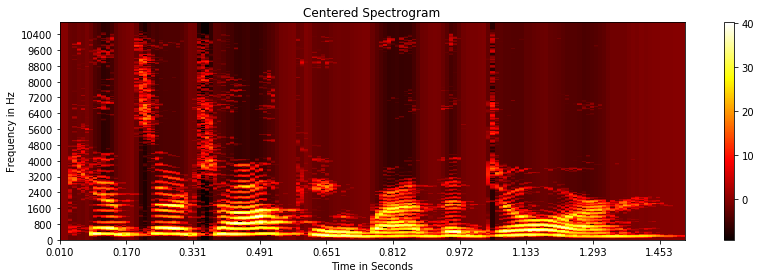

In [129]:
# mean vector
# ToDo: Axis 0 or Axis 1?

#Axis 0 <---
feature_mean = np.mean(spectrogram, axis=0)
centered_spectrogram = spectrogram - feature_mean
#Axis 1
#feature_mean = np.mean(spectrogram, axis=1)
#centered_spectrogram = (spectrogram.T - feature_mean).T
 
plt.figure(figsize=(14,4))
s= plt.imshow(centered_spectrogram, aspect='auto', cmap='hot', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.colorbar(s)
plt.title('Centered Spectrogram')
plt.ylabel('Frequency in Hz')
plt.xlabel('Time in Seconds')
#plt.show()
plt.savefig('../graphics/centered_spectrogram.pdf')

# Frequenz Histogram

The most 'significant' frequency has to be determined as 200.0


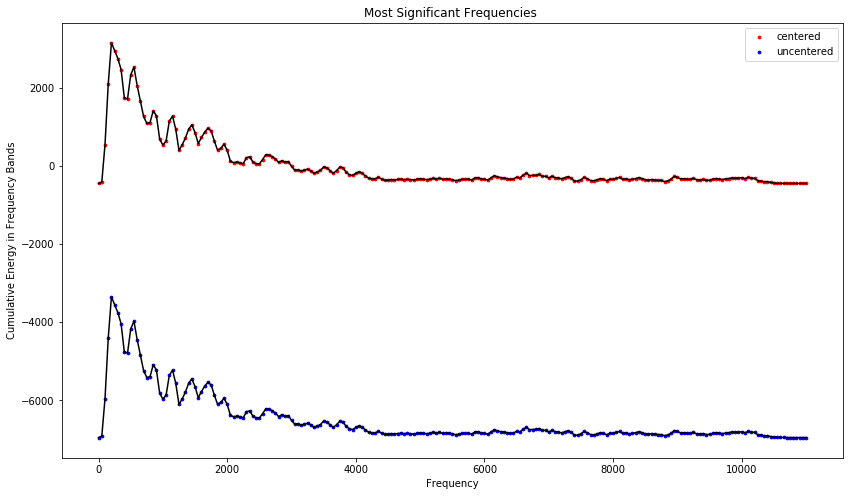

In [130]:

uncentered_sum_frequ = np.sum(spectrogram, axis=1)
sum_frequ = np.sum(centered_spectrogram, axis=1)

significant = freqs[np.argmax(sum_frequ)]
print('The most \'significant\' frequency has to be determined as {}'.format(significant))

markersize=7.5

plt.figure(figsize=(14,8))
plt.scatter(freqs, sum_frequ, color='red',s=markersize , label='centered')
plt.plot(freqs, sum_frequ, color='black')
plt.scatter(freqs, uncentered_sum_frequ, color='blue', s=markersize, label='uncentered')
plt.plot(freqs, uncentered_sum_frequ, color='black')
plt.legend()
plt.ylabel('Cumulative Energy in Frequency Bands')
plt.xlabel('Frequency')
plt.title('Most Significant Frequencies ')
#plt.show()
plt.savefig('../graphics/frequency_histogram.pdf')


In [131]:
#center entire data set

def process_data_set():
    list_sum_frequs = []
    list_labels = []
    for i, file in enumerate(relevant_files_list, 1):
        emotion_number = int(file.split('/')[-1].split('-')[2].lstrip('0'))
        list_labels.append(emotion_number)
        
        raw_samples, sample_rate = librosa.load(file)
        samples, index = librosa.effects.trim(raw_samples, top_db=35)
        freqs, times, spectrogram = log_specgram(samples, sample_rate)
        #Axis 0
        feature_mean = np.mean(spectrogram, axis=0)
        centered_spectrogram = spectrogram - feature_mean
        
        sum_frequ = np.sum(centered_spectrogram, axis=1)
        list_sum_frequs.append(list(sum_frequ))
        
        sys.stdout.write('\riteration {}'.format(i))
        sys.stdout.flush()
    return np.asarray(list_sum_frequs), np.asarray(list_labels), np.mean(list_sum_frequs, axis=0)
        
        
        

In [132]:
#data, labels, mean = process_data_set()

#np.savez('./sum_frequ_data', data=data, labels=labels)
#np.save('./sum_frequ_mean', mean)

# Normalize data

In [133]:
try:
    dataset = np.load('./sum_frequ_data.npz')
    data_mean = np.load('./sum_frequ_mean.npy')
except:
    print('File with num_frequ_mean not found')

entire_dataset_train_x = dataset['data']


####### SANITY CHECK ##################################################################################
# To check the model for correctness, we can shuffle the training set and leave the labels unchanged  
# what essentially means, we assign random labels to the data.                                        
# The test accuracy will then be around 0.125 which is essentially random guessing for 8 classes
#
# Comment-in the following line and re-evaluate the acccuracy to perform the sanity check:
# np.random.shuffle(entire_dataset_train_x)
#
#######################################################################################################

c_entire_dataset_train_x = entire_dataset_train_x - data_mean
normalized_data = normalize(c_entire_dataset_train_x, axis=0)


entire_labelset_train_y = dataset['labels']

shuffle_idx = np.random.permutation(len(normalized_data))
normalized_data_shuffled = normalized_data[shuffle_idx]
labels_shuffled = entire_labelset_train_y[shuffle_idx]

# *Principle Component Analysis*
**==> reduce dimensions from 221 to fewer, meaningful dimensions
The principal components are the largest Eigenvectors of the covariance matrix of the dataset.**

In [134]:
pca = KernelPCA(kernel='rbf', gamma=1.0, n_components=745)
pca.fit(normalized_data_shuffled)
reduced_train_x = pca.transform(normalized_data_shuffled)
print(reduced_train_x.shape)
#print(reduced_train_x)

(1440, 745)


In [135]:
percent_training = 0.8
size_training_set = int(percent_training * len(normalized_data))


train_x, test_x = np.split(reduced_train_x, [size_training_set])
train_y, test_y = np.split(labels_shuffled, [size_training_set])

print("Splitting dataset into {} training- and {} test-samples".format(len(train_y), len(test_y)))



Splitting dataset into 1152 training- and 288 test-samples


## *SVM*

In [136]:

svm_estimator = svm.SVC(C=10.0, kernel='rbf', gamma=10.0)


In [137]:
print(train_x.shape)
reduced_train_x = pca.fit_transform(train_x)
print(reduced_train_x.shape)

(1152, 745)
(1152, 745)


In [138]:
svm_estimator.fit(train_x, train_y)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# *Gridsearch best parameters and best scores*

In [139]:
################## SVM ##################

#svm_estimator = svm.SVC()

#pipe = Pipeline(steps=[('pca',pca),('svm',svm_estimator)])
#parameters = {'pca__n_components': [150,200,250],
#              'pca__gamma': np.logspace(-2,2,5),
#              'svm__C': np.logspace(-2,1,4),
#              'svm__gamma': np.logspace(-2,2,5)}
#
#clf = GridSearchCV(pipe, parameters)
#clf.fit(train_x, train_y)

In [140]:
#print('Best Score: {}'.format(clf.best_score_))
#print('Best Parameters: {}'.format(clf.best_params_))
#estimator = clf.best_estimator_
#print('Best estimator: {}'.format(estimator))

# Best Parameters:
test accuracy: 0.61


Best Score: 0.5928819444444444
Best Parameters: {'pca__gamma': 1.0, 'pca__n_components': 150, 'svm__C': 10.0, 'svm__gamma': 10.0}
Best estimator: Pipeline(memory=None,
     steps=[('pca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=1.0, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=150, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('svm', SVC(C=10.0, cache_si...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

# Evaluate the Model
select one emotion and let it predict by SVM 

In [141]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
label_mapping = {1 : 'neutral',
                2 : 'calm',
                3 : 'happy',
                4 : 'sad',
                5 : 'angry',
                6 : 'fearful', 
                7 : 'disgust',
                8 : 'surprised'}

In [142]:
index = random.randint(0, len(test_x)-1)
print('Das {}. Sample'.format(index))
test_sample = np.expand_dims(test_x[index],0)
test_label = test_y[index]
print('Mit Label {} ({}):'.format(test_label, label_mapping[test_label]))
prediction = svm_estimator.predict(test_sample)[0]
print('The prediction is: {} ({})'.format(prediction, label_mapping[prediction]))

Das 152. Sample
Mit Label 5 (angry):
The prediction is: 5 (angry)


# *Accuracy*

In [143]:
entire_train_predictions = svm_estimator.predict(train_x)
print('The Accuracy of the training set is {}'.format(np.mean(entire_train_predictions==train_y)))
entire_test_predictions = svm_estimator.predict(test_x)
print('The Accuracy of the test training set is {}'.format(np.mean(entire_test_predictions==test_y)))


The Accuracy of the training set is 0.9704861111111112
The Accuracy of the test training set is 0.6388888888888888


# End of SVM Approach

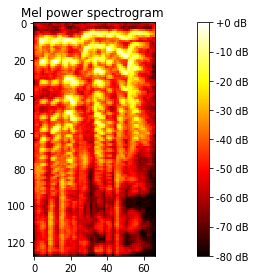

In [144]:
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
#librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.imshow(log_S, cmap='hot')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

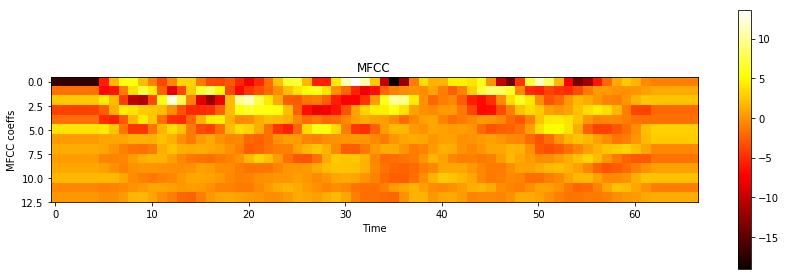

In [145]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
#librosa.display.specshow(delta2_mfcc)
plt.imshow(delta2_mfcc, cmap='hot')
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()